In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os 
import cv2
import gtsam
import gtsam.utils.plot as gtsam_plot
import math
from collections import namedtuple
import itertools

In [7]:
class mosaic:
    def __init__(self):
        self.homography_matrix = None
    
    def apply_clahe_to_image(self,input_image, clip_limit=2.0, tile_grid_size=(8, 8)):
        """
        Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to an input image.

        Args:
            input_image (numpy.ndarray): The input image.
            clip_limit (float): Clip limit for CLAHE. Higher values increase the contrast.
            tile_grid_size (tuple): Size of grid for histogram equalization.

        Returns:
            numpy.ndarray: The output image with CLAHE applied.
        """
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)

        # Apply CLAHE to both images
        output_image = clahe.apply(input_image)
        
        return output_image


    def feature_detector(self,input_image,nfeatures=0,nOctaveLayers=3,contrastThreshold=0.04,edgeThreshold=10,sigma=1.6):
        """
        Apply SIFT feature detector to the input image with customizable parameters.

        Args:
            input_image (numpy.ndarray): The input image.
            nfeatures (int): Number of best features to retain (0 means all features).
            nOctaveLayers (int): Number of layers per octave.
            contrastThreshold (float): Threshold to filter out low-contrast keypoints.
            edgeThreshold (float): Threshold to filter out weak edges.
            sigma (float): The standard deviation of the Gaussian filter applied to the image.

        Returns:
            tuple: A tuple containing keypoints (list) and descriptors (numpy.ndarray).
        """
        
        #Apply Chale to the input images
        input_image = self.apply_clahe_to_image(input_image)
        
        # Create SIFT detector
        sift = cv2.SIFT_create(nfeatures=nfeatures,nOctaveLayers=nOctaveLayers,contrastThreshold=contrastThreshold,edgeThreshold=edgeThreshold,sigma=sigma)

        # Detect key points and compute descriptors for both images
        key_points, descriptors = sift.detectAndCompute(input_image, None)
        
        return key_points,descriptors
    
    def matchers(self,keypoints1,descriptors1,keypoints2,descriptors2,matcher = "FLANN"):
        """
        Apply feature matching on the descriptors using either BFMatcher or FLANN.

        Args:
            descriptors1 (numpy.ndarray): Descriptors from the first set of keypoints.
            descriptors2 (numpy.ndarray): Descriptors from the second set of keypoints.
            matcher (str): The matcher to use, either "BF" for Brute-Force or "FLANN" for FLANN.

        Returns:
            tuple: A tuple containing two NumPy arrays of matched points from descriptors1 and descriptors2.
        """
        
        if matcher == "FLANN":
            # Perform feature matching using FLANN (Fast Library for Approximate Nearest Neighbors) matcher
            flann = cv2.FlannBasedMatcher({'algorithm': 0, 'trees': 5}, {})
            matches = flann.knnMatch(descriptors1, descriptors2, k=2)

            # Apply ratio test to select good matches
            good_matches = []
            for m, n in matches:
                if m.distance < 0.75 * n.distance:
                    good_matches.append(m)

            # Extract matched points
            matched_points1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
            matched_points2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches])
            
            return matched_points1,matched_points2
        
        elif matcher == "BF":
            bf = cv2.BFMatcher()
            matches = bf.knnMatch(descriptors1, descriptors2, k=2)
            
            # Apply ratio test to select good matches
            good_matches = []
            for m, n in matches:
                if m.distance < 0.75 * n.distance:
                    good_matches.append(m)

            # Extract matched points
            matched_points1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
            matched_points2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches])
            
            return matched_points1,matched_points2

    def get_homography(self,matched_points1,matched_points2,ransacReprojThreshold=3, maxIters=2000, confidence=0.995):
        """
        Compute the homography matrix using RANSAC based on matched points between two images with customizable RANSAC parameters.

        Args:
            matched_points1 (numpy.ndarray): Array of matched points from the first image.
            matched_points2 (numpy.ndarray): Array of matched points from the second image.
            ransacReprojThreshold (float): Maximum allowable reprojection error.
            maxIters (int): Maximum number of iterations for RANSAC.
            confidence (float): Desired confidence level (probability) that the estimated model is correct.

        Returns:
            numpy.ndarray: The computed homography matrix.
        """
        if len(matched_points1)>=4:
            # Compute the homography matrix using RANSAC
            H, _ = cv2.findHomography(matched_points1, matched_points2, cv2.RANSAC,ransacReprojThreshold=ransacReprojThreshold, maxIters=maxIters,confidence=confidence)

            self.homography_matrix = H

            return H
        else:
            return "Can't comupte homography between these images"
        
    def get_affine(self,matched_points1,matched_points2,ransacReprojThreshold=3, maxIters=2000, confidence=0.995):
        """
        Compute the Affine matrix using RANSAC based on matched points between two images with customizable RANSAC parameters.

        Args:
            matched_points1 (numpy.ndarray): Array of matched points from the first image.
            matched_points2 (numpy.ndarray): Array of matched points from the second image.
            ransacReprojThreshold (float): Maximum allowable reprojection error.
            maxIters (int): Maximum number of iterations for RANSAC.
            confidence (float): Desired confidence level (probability) that the estimated model is correct.

        Returns:
            numpy.ndarray: The computed Affine matrix.
        """
        # Compute the homography matrix using RANSAC
        H, _ = cv2.estimateAffinePartial2D(matched_points1, matched_points2, cv2.RANSAC,ransacReprojThreshold=ransacReprojThreshold, maxIters=maxIters,confidence=confidence)
        scale = math.sqrt(H[0,0]**2 + H[0,1]**2)
        H[0,:] /=scale
        H[1,:] /=scale
        H=np.vstack((H,[0,0,1]))

        self.homography_matrix = H

        return H

    
    def compute_homography(self,image1,image2):
        """
        Compute the homography matrix between two images using feature detection and matching.

        Args:
            image1 (numpy.ndarray): The first input image.
            image2 (numpy.ndarray): The second input image.

        Returns:
            numpy.ndarray: The computed homography matrix.
        """
        keypoints1,descriptors1 = self.feature_detector(image1,None)
        keypoints2,descriptors2 = self.feature_detector(image2,None)
        
        matched_points1,matched_points2 = self.matchers(keypoints1,descriptors1,keypoints2,descriptors2,matcher="FLANN")
        
        H = self.get_homography(matched_points1,matched_points2)
        
        return H 
    def compute_affine(self,image1,image2):
        """
        Compute the homography matrix between two images using feature detection and matching.

        Args:
            image1 (numpy.ndarray): The first input image.
            image2 (numpy.ndarray): The second input image.

        Returns:
            numpy.ndarray: The computed Affine matrix.
        """
        keypoints1,descriptors1 = self.feature_detector(image1)
        keypoints2,descriptors2 = self.feature_detector(image2)
        
        matched_points1,matched_points2 = self.matchers(keypoints1,descriptors1,keypoints2,descriptors2,matcher="FLANN")
        
        H = self.get_affine(matched_points1,matched_points2)
    
        return H

    def stitch_image(self,image1,image2,H):
        """"
        Create a mosaic between the two images using the given homography between them
        
        Args:
            image1 (numpy.ndarray): The first input image.
            image2 (numpy.ndarray): The second input image.
            H (numpy.ndarray): Homography matrix between the two images

        Returns:
            numpy.ndarray: The combined mosaic between the two images.
        """
        
        im_src = image1 
        im_dst = image2
        canvas = np.zeros(((im_dst.shape[0]+im_src.shape[0]) , (im_dst.shape[1] + im_src.shape[1]), 3), dtype=np.uint8)
        y_offset = ((im_dst.shape[1]+im_src.shape[1]) - im_dst.shape[1]) // 2
        x_offset = ((im_dst.shape[0] + im_src.shape[0]) - im_dst.shape[0]) // 2
        canvas[y_offset:y_offset+im_dst.shape[0], x_offset:x_offset+im_dst.shape[1]] = im_dst
        He = self.compute_homography(im_dst, canvas)
        im_out = cv2.warpPerspective(im_src, np.dot(He,H),((im_dst.shape[1]+im_src.shape[1]) , (im_dst.shape[0] + im_src.shape[0]) ))
        roi_coordinates = cv2.findNonZero(cv2.cvtColor(canvas, cv2.COLOR_BGR2GRAY))
        mask = np.zeros_like(im_out)
        cv2.fillPoly(mask, [np.array(roi_coordinates)], (255, 255, 255))

        # Paste image2 onto the ROI
        result = im_out.copy()
        im_out = np.where(mask == 255, canvas, result)

        non_zero_pixels = cv2.findNonZero(cv2.cvtColor(im_out, cv2.COLOR_BGR2GRAY))

        # Get the bounding box of the non-zero pixels
        x, y, w, h = cv2.boundingRect(non_zero_pixels)

        # Crop the image to the bounding box
        cropped_im_out = im_out[y:y+h, x:x+w]
        return cropped_im_out
        
        

In [32]:
class factorgraph:
    def __init__(self): 
        self.my_mosaic = mosaic()
        self.Graphbin = namedtuple('Graphbin','im pts')
        self.siftPts = namedtuple('siftPts', 'k d')
        self.Point = namedtuple('Point', 'x y')
       
    def sticher(self,warps: list,dim,blend=True,scale=1):
        """
        Stitch all the images in the warps list together to create a combined image.

        Args:
            warps (list): A list of warped images.
            dim (array): The dimensions of the canvas.
            blend (bool): Whether to blend the images (default is True).
            scale (float): Scaling factor for resizing (default is 1).

        Returns:
            numpy.ndarray: The computed Affine matrix.
        """
        dest = warps[0]
        dest = cv2.resize(dest, (0,0), fx=scale, fy=scale)
        if blend == True:
            for ind in range(1,len(warps)):
                warps[ind] = cv2.resize(warps[ind], (0,0), fx=scale, fy=scale)
                out_mask=np.any(warps[ind],2)
                out_mask=np.repeat(out_mask[:,:,np.newaxis], 3, axis=2)
                out_dest_mask=np.any(dest,2)
                out_dest_mask=np.repeat(out_dest_mask[:,:,np.newaxis], 3, axis=2)
                mask_result=np.bitwise_and(out_mask,out_dest_mask).astype("uint8")


                result = cv2.addWeighted(warps[ind], 0.5, dest, 0.5, 0)#create our blend

                mask_result=(cv2.cvtColor(mask_result, cv2.COLOR_BGR2GRAY))

                output=cv2.bitwise_and(result,result,mask=mask_result)
                result=cv2.subtract(result,output)
                result=cv2.add(result,result)
                dest = cv2.add(output, result)

        else:

            for ind in range(1,len(warps)):
                warps[ind] = cv2.resize(warps[ind], (0,0), fx=scale, fy=scale)

                out_mask=np.any(warps[ind],2)
                out_mask=np.repeat(out_mask[:,:,np.newaxis], 3, axis=2)
                out_dest_mask=np.any(dest,2)
                out_dest_mask=np.repeat(out_dest_mask[:,:,np.newaxis], 3, axis=2)
                mask_result=np.bitwise_and(out_mask,out_dest_mask).astype("uint8")



                mask_result=(cv2.cvtColor(mask_result, cv2.COLOR_BGR2GRAY))

                output=cv2.bitwise_and(dest,dest,mask=mask_result)
                result=cv2.subtract(dest,output)
                dest = cv2.add(warps[ind], result)



        return dest

    def gtloader(self, folder):
        """
        Load images from a specified folder, detect features, and store images and points.

        Args:
            folder (str): The folder containing image files.

        Returns:
            list: A list of tuples, each containing an image and its associated feature points.
        """
        # Create a list to store image file paths
        im_paths = []

        # Iterate through files in the specified folder
        for file in os.listdir(folder):
            if ".tif" in file:
                # If the file has a ".tif" extension, add its full path to the list
                im_paths.append(os.path.join(folder, file))

        # Sort the list of image paths
        im_paths.sort()

        # Create a list to store images and their corresponding points
        imgsAndPts = []

        # Iterate through each image path and process it
        for image in im_paths:
            # Read the image using OpenCV
            img = cv2.imread(image)

            # Resize the image (no scaling is applied here, as fx and fy are both 1)
            img = cv2.resize(img, (0, 0), fx=1, fy=1)

            # Detect features (keypoints and descriptors) in the image using a custom function
            k, d = self.my_mosaic.feature_detector(img)

            # Extract SIFT points and create a tuple with the image and points
            imgsAndPts.append(self.Graphbin(img, self.siftPts(k, d)))

        return imgsAndPts


    def dimFind(self, Panorama: dict):
        """
        Calculate the dimensions and transformation matrix for a panorama.

        Args:
            Panorama (dict): A dictionary containing information about the panorama, including images and homography matrices.

        Returns:
            tuple: A tuple containing the dimensions (width and height) of the panorama and the transformation matrix (transH).
        """
        transPts = []

        # Iterate through each part of the panorama
        for part in Panorama["panopart"]:
            img1 = part["img"]
            H1 = part["H"]
            h1, w1 = img1.shape[:2]  # Grab height and width from the input image

            # Create an array of just the corners in order: top left, top right, bottom left, bottom right
            pts1 = (self.Point(0, 0), self.Point(0, h1), self.Point(w1, h1), self.Point(w1, 0))

            for pt in pts1:
                transPts.append(np.matmul(H1, np.array([pt[0], pt[1], 1])))  # Matmul the corners by the homography

        # Calculate the minimum and maximum x and y coordinates
        x_min = min(pt[0] / pt[2] for pt in transPts)
        x_max = max(pt[0] / pt[2] for pt in transPts)

        y_min = min(pt[1] / pt[2] for pt in transPts)
        y_max = max(pt[1] / pt[2] for pt in transPts)

        # Determine the x_shift and y_shift
        if x_min < 0:
            x_shift = abs(x_min)
        elif x_min > 0:
            x_shift = 0
        else:
            x_shift = 0

        if y_min < 0:
            y_shift = abs(y_min)
        elif y_min > 0:
            y_shift = 0
        else:
            y_shift = 0

        # Create the transformation matrix
        transH = np.array([[1, 0, np.ceil(x_shift)], [0, 1, np.ceil(y_shift)], [0, 0, 1]])

        # Calculate the final dimensions with some additional margin
        dim = (int(x_max + x_shift * 1.2), int(y_max + y_shift * 1.2))

        return dim, transH


    def warper(self, Panorama: dict):
        """
        Warp images in a panorama using homography matrices.

        Args:
            Panorama (dict): A dictionary containing information about the panorama, including images and homography matrices.

        Returns:
            list: A list of warped images using homography transformations.
        """
        warps = []

        # Iterate through each part of the panorama
        for panopart in Panorama["panopart"]:
            # Warp the image using the provided homography matrix and interpolation method
            warped_img = cv2.warpPerspective(panopart["img"], panopart["H"], Panorama["canvas"], flags=cv2.INTER_NEAREST)

            # Append the warped image to the list
            warps.append(warped_img)

        return warps

    
    def get_gtsam_pose2(self, affine_matrix):
        """
        Create a GTSAM Pose2 object from an affine matrix.

        Args:
            affine_matrix (numpy.ndarray): The affine matrix representing a 2D transformation.

        Returns:
            gtsam.Pose2: A GTSAM Pose2 object representing the 2D pose.
        """
        # Extract translation and rotation information from the affine matrix
        translation = [affine_matrix[0, -1], affine_matrix[1, -1]]
        rotation = np.arctan2(affine_matrix[1, 0], affine_matrix[0, 0])

        # Create a GTSAM Pose2 object
        pose2 = gtsam.Pose2(translation[0],translation[1], rotation)

        return pose2

    
    def plot_graph(self, values, graph, marginals, title):
        """
        Plot a graph of Poses and their connections.

        Args:
            values (gtsam.Values): The values containing Poses.
            graph (gtsam.NonlinearFactorGraph): The factor graph containing edges.
            marginals (gtsam.Marginals): The marginal covariances of the Poses.
            title (str): The title of the plot.
        """
        # Plot each Pose in the graph
        for vertex_index in range(values.size()):
            gtsam_plot.plot_pose2(0, values.atPose2(vertex_index), 0.5, marginals.marginalCovariance(vertex_index))

        # Plot connections between Poses
        for edge_index in range(1, graph.size()):  # Start from index 1 (skip the first element)
            key1, key2 = graph.at(edge_index).keys()
            start_pose = values.atPose2(key1)
            end_pose = values.atPose2(key2)
            plt.plot([start_pose.x(), end_pose.x()], [start_pose.y(), end_pose.y()], color='blue')

        plt.title(title)
        plt.show()


    def noisyMatch(self, pts1, pts2):
        """
        Compute a noisy match between two sets of points and estimate an affine transformation.

        Args:
            pts1: A set of keypoints and descriptors for the first image.
            pts2: A set of keypoints and descriptors for the second image.

        Returns:
            H: The estimated affine transformation.
            gtsam_noise: A GTSAM noise model.
        """
        # Use a custom matcher to find correspondences between points in pts1 and pts2
        m1, m2 = self.my_mosaic.matchers(pts2.k, pts2.d, pts1.k, pts1.d)

        # Check if there are enough correspondences to estimate the transformation
        if len(m1) < 6:
            return None, None

        # Estimate the affine transformation between the sets of points
        H = self.my_mosaic.get_affine(m1, m2)
        pose = self.get_gtsam_pose2(H)
        
        ERF_DIV = 50
        LIN_DIV = 30
        covar_multiplier = 1/math.erf((len(m1)-3)/ERF_DIV)

        exx = abs(pose.x()/LIN_DIV) * covar_multiplier
        eyy = abs(pose.y()/LIN_DIV) * covar_multiplier
        ett = abs(pose.theta()/(LIN_DIV * 10.0)) * covar_multiplier
        diag_noise = np.array([exx,eyy,ett])

#         # Define noise levels for translation and rotation
#         diag_noise = covar_multiplier * np.array([1, 1, np.deg2rad(1)])
        # diag_noise = 1000 * len(m1) ** -2 * np.array([1, 1, np.deg2rad(1)])

        # Create a GTSAM noise model with diagonal covariances
        gtsam_noise = gtsam.noiseModel.Diagonal.Sigmas(diag_noise)

        return H, gtsam_noise

    

    def gtimshow(self, imgsAndPts, graph, initial, blend=False, scale=1):
        """
        Create a panorama image from a list of images and their corresponding graph and initial poses.

        Args:
            imgsAndPts: A list of images and their associated feature points.
            graph: The factor graph representing the graph structure.
            initial: Initial poses of the images.
            blend (bool): Whether to blend the images (default is False).
            scale (float): Scaling factor for resizing (default is 1).

        Returns:
            numpy.ndarray: The final stitched panorama image.
        """
        # Create a dictionary to store panorama parts
        Panorama = {"panopart": []}

        # Extract affine matrices from initial poses
        poses = gtsam.utilities.allPose2s(initial)
        affine_matrix_list = []
        for index in range(len(imgsAndPts)):
            pose = poses.atPose2(index)
            affine_matrix = pose.matrix()
            affine_matrix_list.append(affine_matrix)

        # Iterate through images and their affine matrices
        for ind in range(len(imgsAndPts)):
            Panorama["panopart"].append({"img": imgsAndPts[ind].im, "H": affine_matrix_list[ind]})

        # Calculate the dimensions and translation for the final canvas
        Panorama['canvas'], transH = self.dimFind(Panorama)

        # Apply translation to all homographies
        for panopart in Panorama["panopart"]:
            panopart["H"] = np.matmul(transH, panopart["H"])

        # Warp the images
        warps = self.warper(Panorama)

        # Blend the images together
        panoFinal = self.sticher(warps, Panorama["canvas"], blend, scale)

        return panoFinal


    def gtbuild(self, folder):
        """
        Build a factor graph for the images in the given folder and initialize it.

        Args:
            folder (str): The folder containing image files.

        Returns:
            gtsam.NonlinearFactorGraph: The factor graph representing the relationships between images.
            gtsam.Values: Initial poses and values for the images.
            list: A list of images and their associated feature points.
        """
        # Load images and their corresponding feature points
        imgsAndPts = self.gtloader(folder)

        # Create a diagonal noise model for prior factors
        prior_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3, 0.3, np.deg2rad(1)]))  # Diagonal noise model

        # Initialize a values container
        initial = gtsam.Values()

        # Initialize a factor graph
        graph = gtsam.NonlinearFactorGraph()

        im_height, im_width = (imgsAndPts[0].im).shape[:2]
        cam_matrix = np.array([[1, 0, im_width / 2],
                               [0, 1, im_height / 2],
                               [0, 0, 1]])

        # Add a prior factor for the first image (center of the image)
        graph.add(gtsam.PriorFactorPose2(0, gtsam.Pose2(im_width / 2, im_height / 2, 0), prior_noise))

        total_affine_matrix, initial = self.gtinit(imgsAndPts, initial)

        for srcInd, dstInd in itertools.combinations(range(len(imgsAndPts)), 2):

            if srcInd + 1 == dstInd:  # If the images are neighbors, assume a match

                affine_matrix, gtsam_noise = self.noisyMatch(imgsAndPts[srcInd].pts, imgsAndPts[dstInd].pts)

                total_affine_matrix = affine_matrix.dot(total_affine_matrix)

                # Add a factor representing the transformation between two neighboring images
                graph.add(gtsam.BetweenFactorPose2(srcInd, dstInd, self.get_gtsam_pose2(affine_matrix), gtsam_noise))

            elif cv2.norm(initial.atPose2(srcInd).translation() - initial.atPose2(dstInd).translation()) < im_width * 0.8:
                affine_matrix, gtsam_noise = self.noisyMatch(imgsAndPts[srcInd].pts, imgsAndPts[dstInd].pts)
                if type(affine_matrix) is not type(None):

                    total_affine_matrix = affine_matrix.dot(total_affine_matrix)

                    # Add a factor representing the transformation between two non-neighboring images
                    graph.add(gtsam.BetweenFactorPose2(srcInd, dstInd, self.get_gtsam_pose2(affine_matrix), gtsam_noise))

        return graph, initial, imgsAndPts


    def gtinit(self, imgsAndPts, initial):
        """
        Initialize poses and a total affine matrix for the images.

        Args:
            imgsAndPts: A list of images and their associated feature points.
            initial: Initial values for the images.

        Returns:
            numpy.ndarray: The total affine transformation matrix.
            gtsam.Values: Initial poses and values for the images.
        """
        # Initialize the total affine matrix as an identity matrix
        total_affine_matrix = np.eye(3)

        # Insert an initial pose for the first image (identity transformation)
        initial.insert(0, gtsam.Pose2())

        for srcInd in range(len(imgsAndPts) - 1):
            dstInd = srcInd + 1

            # Compute the affine matrix and GTSAM noise for the transformation
            affine_matrix, gtsam_noise = self.noisyMatch(imgsAndPts[srcInd].pts, imgsAndPts[dstInd].pts)

            # Update the total affine matrix
            total_affine_matrix = affine_matrix.dot(total_affine_matrix)

            # Insert the GTSAM pose for the destination image
            initial.insert(dstInd, self.get_gtsam_pose2(total_affine_matrix))

        return total_affine_matrix, initial

    
    def create_graph(self, path):
        """
        Create a graph, initialize it, and visualize it.

        Args:
            path (str): The path to the folder containing image files.

        Returns:
            tuple: A tuple containing images and their associated feature points, the factor graph, and initial poses.
        """
        # Build the factor graph, initialize it, and get images with feature points
        graph, initial, imgsAndPts = self.gtbuild(path)

        # Calculate marginal covariances
        marginals = gtsam.Marginals(graph, initial)

        # Plot the initial graph
        self.plot_graph(initial, graph, marginals, "initial")

        # Create a figure for displaying the stitched panorama
        plt.figure(figsize=(16, 16))

        # Display the stitched panorama
        plt.imshow(self.gtimshow(imgsAndPts, graph, initial))

        # Return images, graph, and initial poses
        return imgsAndPts, graph, initial

        
    def optimize_graph(self, imgsAndPts, graph, initial):
        """
        Optimize the factor graph and visualize the final result.

        Args:
            imgsAndPts: A list of images and their associated feature points.
            graph: The factor graph representing the relationships between images.
            initial: Initial poses and values for the images.

        Returns:
            tuple: A tuple containing the optimized factor graph and initial poses.
        """
        # Define optimization parameters
        params = gtsam.LevenbergMarquardtParams()

        # Create a Levenberg-Marquardt optimizer and optimize the graph
        optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)
        initial = optimizer.optimize()

        # Calculate marginal covariances
        marginals = gtsam.Marginals(graph, initial)

        # Plot the final graph after optimization
        self.plot_graph(initial, graph, marginals, "final")

        # Create a figure for displaying the stitched panorama
        plt.figure(figsize=(16, 16))

        # Display the final stitched panorama
        plt.imshow(self.gtimshow(imgsAndPts, graph, initial))

        # Return the optimized factor graph and initial poses
        return graph, initial





# 1(a) 6images stiching 

## For this task, I iterated through the images, taking the first two images and finding a homography between them. Then, I considered the combined image as the source image and the next image as the destination image. I repeated this process until I reached the end of the data set.

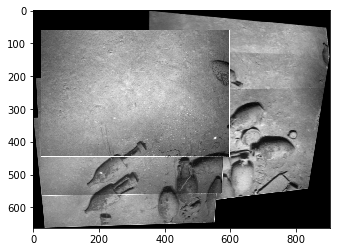

In [23]:
image1 = cv2.imread(f'/home/mobiman/alpharomeo911/hw3/6Images/1.tif')  # Load the first image
my_homography = mosaic()
# Loop to match sequential images (1-2, 2-3, ..., 5-6)
for i in range(1,6):
    image2 = cv2.imread(f'/home/mobiman/alpharomeo911/hw3/6Images/{i+1}.tif')  # Load image i
    H = my_homography.compute_homography(image1,image2)
    cropped_im_out = my_homography.stitch_image(image1,image2,H)
    image1 = cropped_im_out
    
plt.imshow(image1)


# 1(b) Generation and optimization of a pose graph using six images dataset.

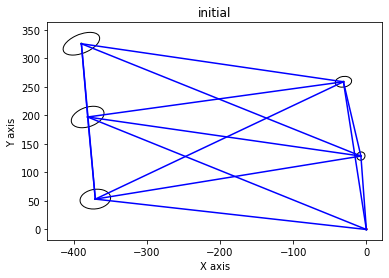

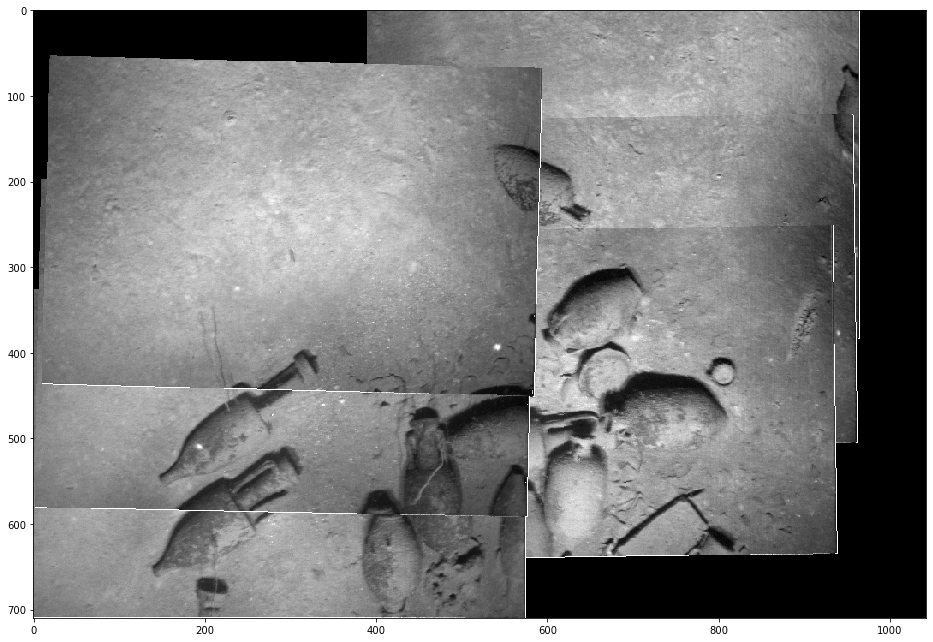

In [33]:
my_factor = factorgraph()
imgAndPts,graph,initial = my_factor.create_graph("/home/mobiman/alpharomeo911/hw3/6Images")

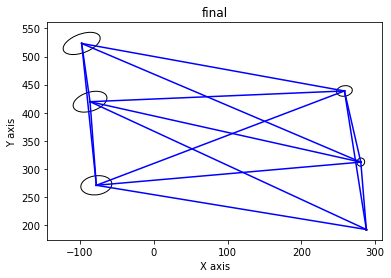

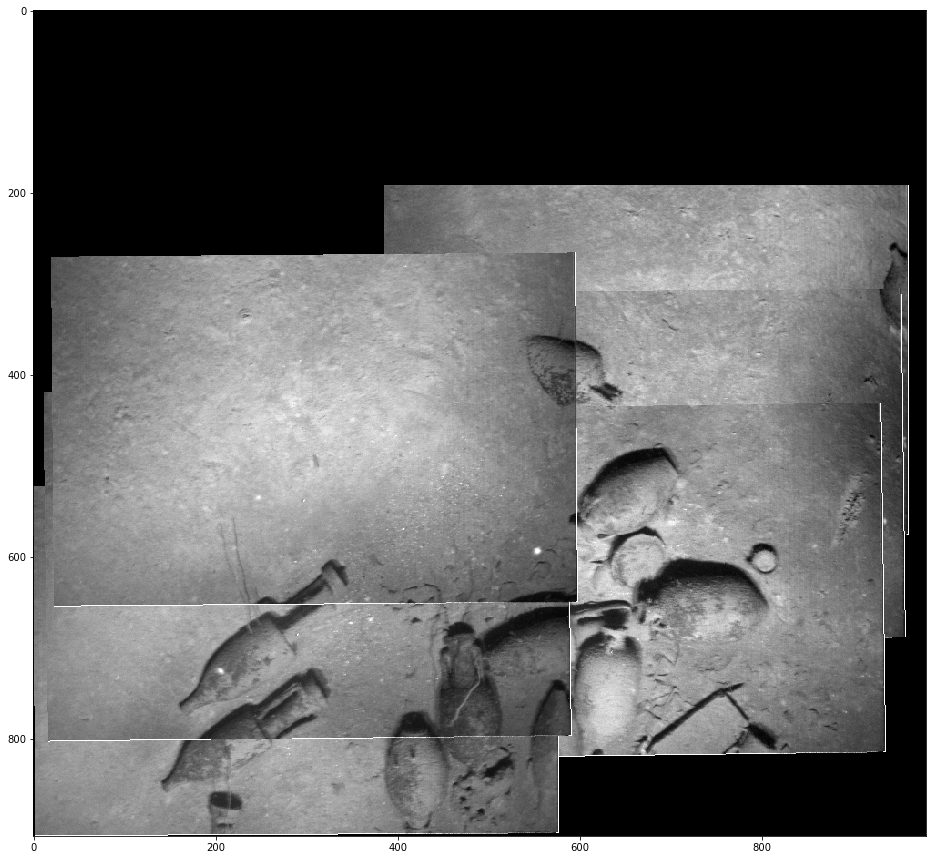

In [34]:
graph,initial = my_factor.optimize_graph(imgAndPts,graph,initial)

# 2 Generation and optimization of a pose graph using 29 images dataset.

<ipython-input-7-8a5522300436>:140: RuntimeWarning: divide by zero encountered in divide
  H[0,:] /=scale
<ipython-input-7-8a5522300436>:140: RuntimeWarning: invalid value encountered in divide
  H[0,:] /=scale
<ipython-input-7-8a5522300436>:141: RuntimeWarning: divide by zero encountered in divide
  H[1,:] /=scale
<ipython-input-7-8a5522300436>:141: RuntimeWarning: invalid value encountered in divide
  H[1,:] /=scale


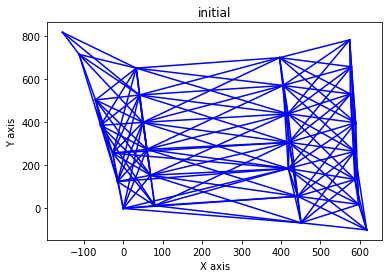

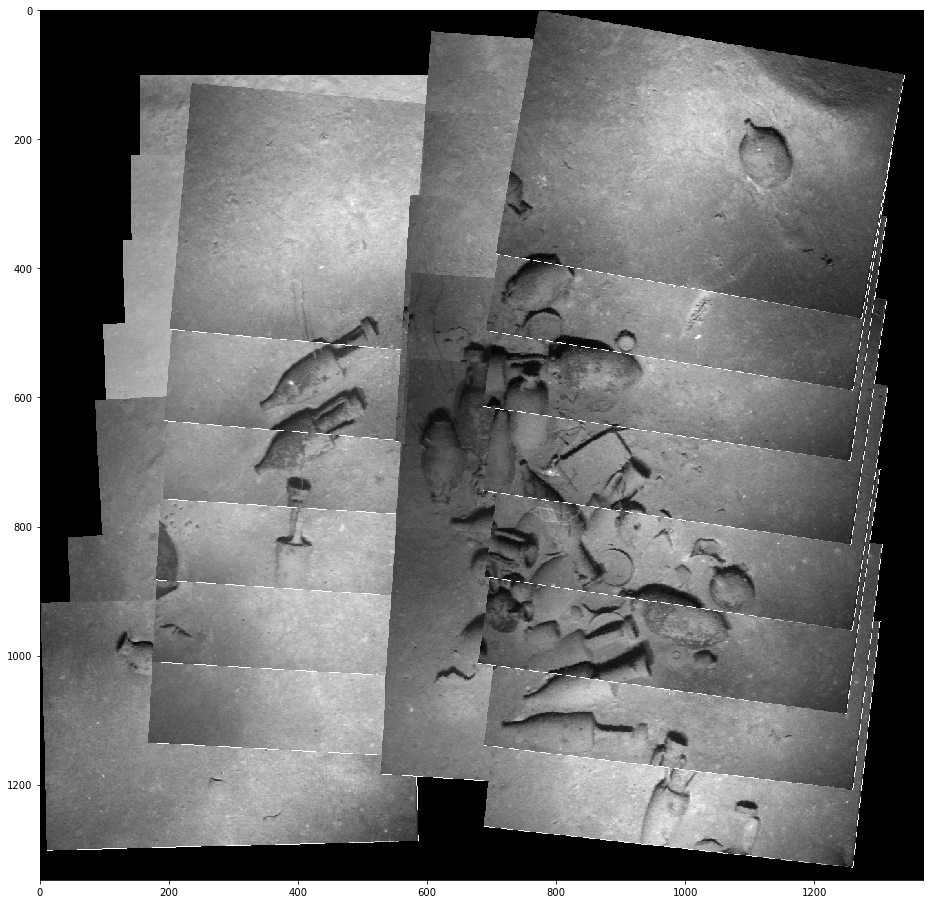

In [35]:
my_factor = factorgraph()
imgAndPrs,graph,initial = my_factor.create_graph("/home/mobiman/alpharomeo911/hw3/29imagess")

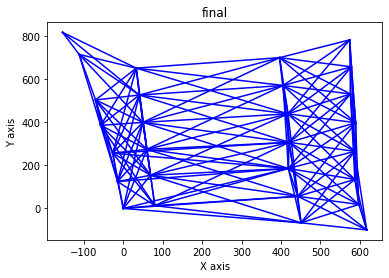

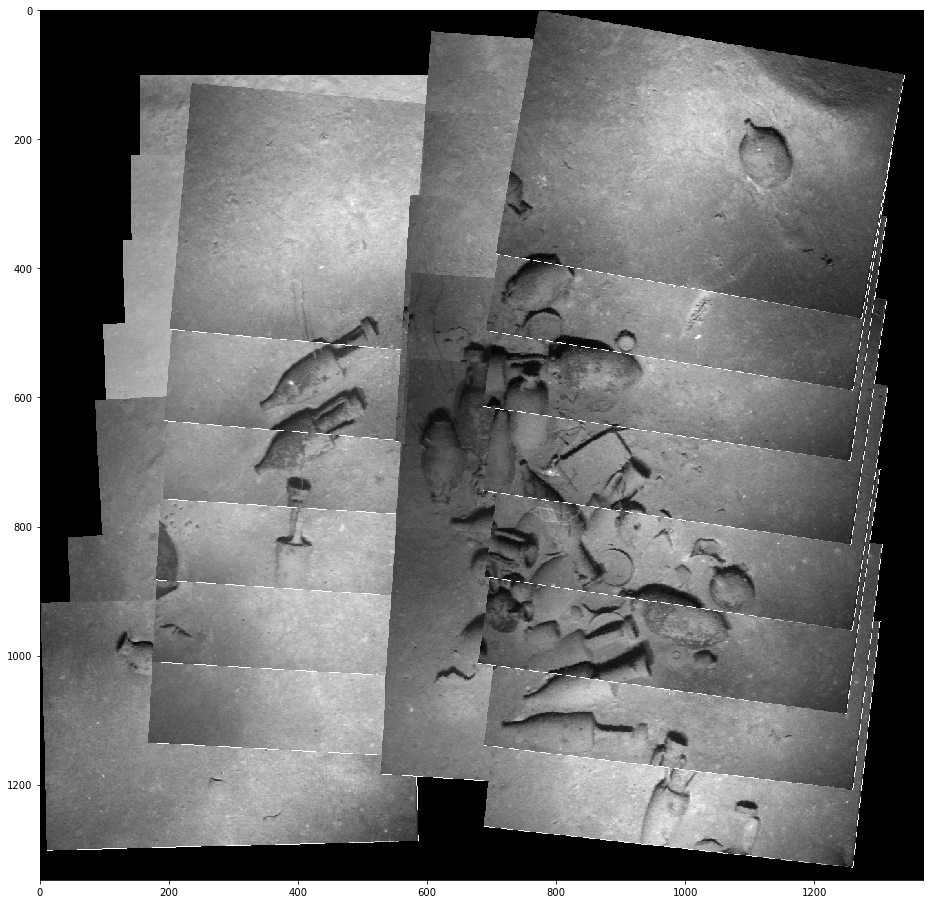

In [28]:
graph,initial = my_factor.optimize_graph(imgAndPrs,graph,initial)

# 3) Generation and optimization of a pose graph using full images dataset.

<ipython-input-7-8a5522300436>:140: RuntimeWarning: divide by zero encountered in divide
  H[0,:] /=scale
<ipython-input-7-8a5522300436>:140: RuntimeWarning: invalid value encountered in divide
  H[0,:] /=scale
<ipython-input-7-8a5522300436>:141: RuntimeWarning: divide by zero encountered in divide
  H[1,:] /=scale
<ipython-input-7-8a5522300436>:141: RuntimeWarning: invalid value encountered in divide
  H[1,:] /=scale


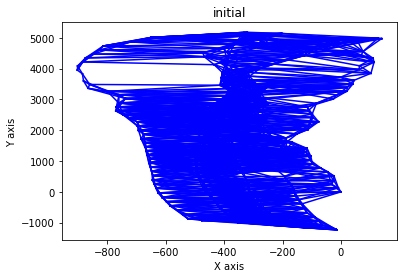

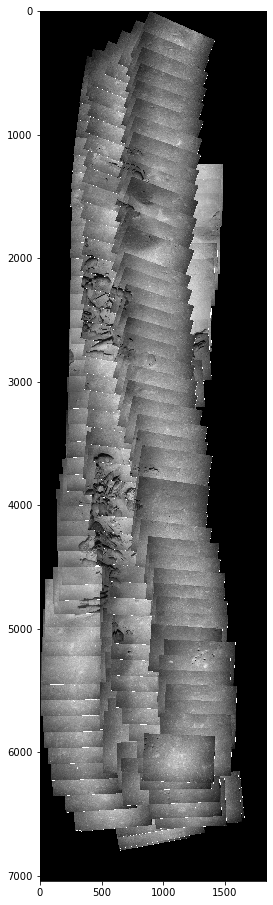

In [36]:
my_factor = factorgraph()
imgAndPrs,graph,initial = my_factor.create_graph("/home/mobiman/alpharomeo911/hw3/allimages")

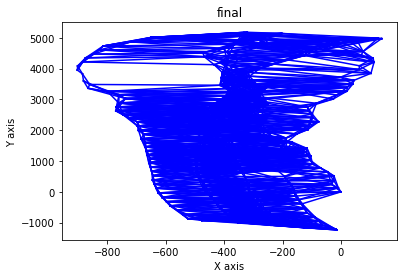

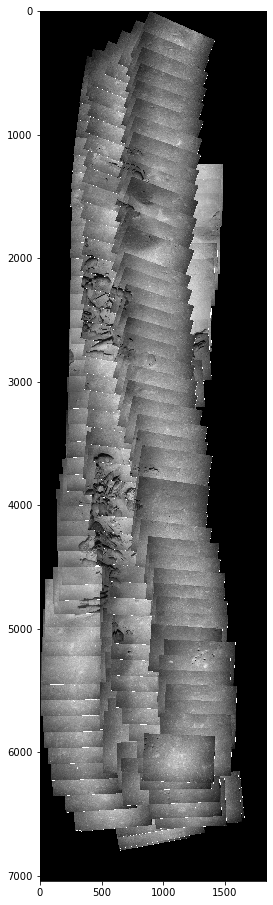

In [37]:
graph,initial = my_factor.optimize_graph(imgAndPrs,graph,initial)

In [31]:
initial

Values with 245 values:
Value 0: (gtsam::Pose2)
(0, 0, 0)

Value 1: (gtsam::Pose2)
(-9.08041, 128.171, -0.00747196)

Value 2: (gtsam::Pose2)
(-31.8083, 243.878, -0.0147315)

Value 3: (gtsam::Pose2)
(-24.3968, 364.77, -0.00727114)

Value 4: (gtsam::Pose2)
(-23.6615, 511.914, -0.00488909)

Value 5: (gtsam::Pose2)
(-45.4469, 649.03, -0.0182972)

Value 6: (gtsam::Pose2)
(-70.0913, 778.299, -0.0226503)

Value 7: (gtsam::Pose2)
(-97.0564, 900.146, -0.0169006)

Value 8: (gtsam::Pose2)
(-104.848, 1025.89, -0.0242134)

Value 9: (gtsam::Pose2)
(-103.507, 1159.1, -0.0395003)

Value 10: (gtsam::Pose2)
(-119.563, 1289.58, -0.0555318)

Value 11: (gtsam::Pose2)
(-116.057, 1408.74, -0.0736966)

Value 12: (gtsam::Pose2)
(-167.91, 1620.21, -0.0627148)

Value 13: (gtsam::Pose2)
(-227.586, 1721.22, -0.0430175)

Value 14: (gtsam::Pose2)
(-275.406, 1828.62, -0.0291156)

Value 15: (gtsam::Pose2)
(-253.207, 1957.26, -0.0383481)

Value 16: (gtsam::Pose2)
(-275.914, 2091.87, -0.0422453)

Value 17: (gtsam::Pose2

# References 
https://gtsam.org/tutorials/intro.html

https://github.com/RainerKuemmerle/g2o/wiki/File-Format

https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python

https://github.com/gtbook/gtsam-examples

https://gtbook.github.io/gtsam-examples/intro.html

ZZ's code

Curtis code